In [1]:
import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

## Dataset

In [18]:
# number of blocks
rows = 100

# defining pixel values with a block which is likely to be an edge block
#e.g. tensor([[113,  22, 194, 228]], requires_grad=True)
pix_vals = np.random.randint(0, 256, size=(1, 4)) 

for i in range(rows//2):
    
    # 4 random digits between 0 to 255 with differences of at most 15
    # e.g. rand_num=66 => choices between 51 to 66 => tensor([[56, 58, 65, 63]], requires_grad=True)
    rand_num = np.random.randint(15, 256)
    smooth = np.random.randint(rand_num-15, rand_num, size=(1, 4))
    
    # adding smooth blocks to pix_vals
    pix_vals = np.vstack((pix_vals, smooth))

for i in range(rows//2-1):
    
    edge = np.random.randint(0, 256, size=(1, 4))
    
    # adding edge blocks to pix_vals
    pix_vals = np.vstack((pix_vals, edge))
    

# calculate differences of pixel values of the first pixels and other three pixels
# e.g. difference1 = tensor([[ 35],
                            # [  2],
                            # [  5],
                            # [  1], ...
difference1 = np.abs(pix_vals[:,0] - pix_vals[:,1]).reshape(-1, 1)
difference2 = np.abs(pix_vals[:,0] - pix_vals[:,2]).reshape(-1, 1)
difference3 = np.abs(pix_vals[:,0] - pix_vals[:,3]).reshape(-1, 1)

# e.g. differences = tensor([[ 35,  72,  71],
                            # [  2,   1,   2],
                            # [  5,   5,   1],
                            # [  1,  10,  10], ...
differences = np.concatenate((difference1, difference2, difference3), axis=1)


diff_binary = differences <= 15
# e.g. tensor([[False, False, False],
             # [ True,  True,  True],
            # [ True,  True,  True],
             # [ True,  True,  True], ...
            

# each row of target is true if the corresponding row of diff_binary includes three true's
target = np.all(diff_binary, axis=1).reshape(-1, 1)

target2 = ~target

target = target.astype(np.int8)

target2 = target2.astype(np.int8)

target = target * 2 - 1 # shift label from {0, 1} to {-1, 1}


# shuffling data including pixel values and their targets
data = np.array(pix_vals, requires_grad=False)
data = np.hstack((data, np.array(target, requires_grad=False)))

np.random.shuffle(data)

X = data[:, :4]
Y = data[:, 4]

## Quantum

In [9]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, interface="autograd")

def circuit(weights, x):
        
    qml.AngleEmbedding(features=x, wires=range(4), rotation='Y')
    qml.Hadamard(0)

    qml.StronglyEntanglingLayers(weights=weights, wires=range(4))
    
    return qml.expval(qml.PauliX(0))


shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=4)
weights = np.random.randn(shape[0], shape[1], shape[2])
print(circuit(weights, X[0]))
print(qml.draw(circuit, expansion_strategy="device")(weights, X[0:2]))


0.028946903358788523
0: ──RY(M0)──H─────────────────────Rot(0.02,-0.16,-0.57)─╭●───────╭X─┤  <X>
1: ──RY(M1)──Rot(1.77,0.03,-0.13)────────────────────────╰X─╭●────│──┤     
2: ──RY(M2)──Rot(-1.45,0.09,0.75)───────────────────────────╰X─╭●─│──┤     
3: ──RY(M3)──Rot(1.45,0.65,-2.03)──────────────────────────────╰X─╰●─┤     
M0 = 
[120 202]
M1 = 
[182 212]
M2 = 
[188 203]
M3 = 
[156 205]


In [4]:
def mae(Y, predictions):
    return np.mean(np.abs(predictions - Y))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def cost(weights, bias, x, y):
    predictions = variational_classifier(weights, bias, X)
    return mae(Y, predictions)
    
def accuracy(labels, predictions, error=0.3):
    true_num = np.sum(np.abs(predictions - labels) <= error)
    return true_num.item()/len(labels)


epoch: 1 | Cost: 0.9904382181767947 | Accuracy: 0.0
epoch: 2 | Cost: 0.9720249311224933 | Accuracy: 0.0
epoch: 3 | Cost: 0.9485245674990338 | Accuracy: 0.0
epoch: 4 | Cost: 0.9252321616949439 | Accuracy: 0.0
epoch: 5 | Cost: 0.9066047979093729 | Accuracy: 0.0
epoch: 6 | Cost: 0.8931946577261307 | Accuracy: 0.0
epoch: 7 | Cost: 0.8822747935303579 | Accuracy: 0.0
epoch: 8 | Cost: 0.8707677973149308 | Accuracy: 0.0
epoch: 9 | Cost: 0.8576380880939781 | Accuracy: 0.02
epoch: 10 | Cost: 0.84366750795734 | Accuracy: 0.03
epoch: 11 | Cost: 0.8307657736199039 | Accuracy: 0.02
epoch: 12 | Cost: 0.8222271395472034 | Accuracy: 0.02
epoch: 13 | Cost: 0.819894776000304 | Accuracy: 0.02
epoch: 14 | Cost: 0.8206475607909987 | Accuracy: 0.02
epoch: 15 | Cost: 0.8186782274133445 | Accuracy: 0.02
epoch: 16 | Cost: 0.8111370322877931 | Accuracy: 0.01
epoch: 17 | Cost: 0.8005692935595409 | Accuracy: 0.01
epoch: 18 | Cost: 0.791903070675553 | Accuracy: 0.01
epoch: 19 | Cost: 0.7867177661480236 | Accuracy: 

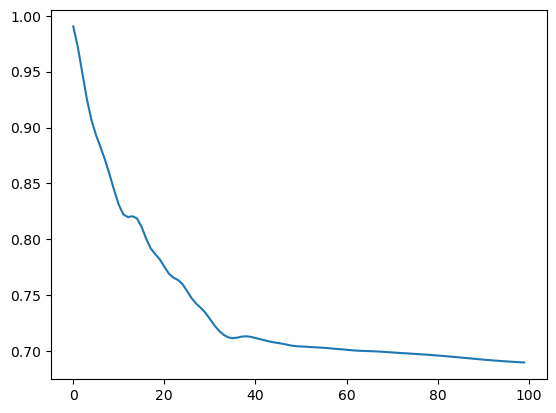

In [17]:
epochs = 100

# opt = qml.GradientDescentOptimizer(.8)
opt = qml.MomentumOptimizer(stepsize=0.5, momentum=0.9)

shape = qml.StronglyEntanglingLayers.shape(n_layers=6, n_wires=4)
weights = np.random.randn(shape[0], shape[1], shape[2])

bias = np.zeros(1)

batch_size = 5 

cost_graph = []

for epoch in range(epochs):
    # update the circuit parameters
    
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, _, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)
        
    epoch_cost= cost(weights, bias, X, Y)
    cost_graph.append(epoch_cost)
    
    # Compute accuracy
    # predictions = np.sign(variational_classifier(weights, bias, X))
    predictions = variational_classifier(weights, bias, X)
    acc = accuracy(Y, predictions, error=0.3)
    
    print("epoch:", epoch + 1, "| Cost:", epoch_cost, "| Accuracy:", acc)

plt.plot(range(epochs), cost_graph)

In [34]:
data

tensor([[106,  55,  60,  16,  -1],
        [  4,   9,   9,  16,   1],
        [ 86, 175, 184,   5,  -1],
        [ 82,  89,  80,  80,   1],
        [138, 183, 105, 150,  -1],
        [181, 177, 179, 179,   1],
        [221, 232, 229, 220,   1],
        [  3,  14,  12,   6,   1],
        [212,  46, 137, 221,  -1],
        [ 16,  20,  13,  19,   1],
        [ 20,  29,  28,  18,   1],
        [165, 163, 164, 176,   1],
        [200, 212, 199, 212,   1],
        [ 16,   9,   9,  11,   1],
        [115, 109, 104, 112,   1],
        [121, 125, 133, 126,   1],
        [162, 160, 160, 165,   1],
        [ 66, 169, 173,  32,  -1],
        [191, 189, 178, 191,   1],
        [118,  36, 199,  84,  -1],
        [ 62,  63,  56,  66,   1],
        [ 26,  82,  52,  34,  -1],
        [ 30, 114, 179, 201,  -1],
        [147, 153,   1, 187,  -1],
        [149, 236, 176, 177,  -1],
        [  4,  16,  13,  11,   1],
        [ 94, 217, 221, 110,  -1],
        [151, 112, 192, 160,  -1],
        [219,  26, 1

In [35]:
print(circuit(weights, X))

[-0.4094341   0.62416746 -0.6282953   0.17780417  0.09287634  0.13957998
  0.89548706  0.27898807 -0.59036374  0.17128052  0.61250779  0.86653976
 -0.07046194  0.35200497  0.8013439   0.92717648 -0.22113428  0.03776049
  0.39168982 -0.25965323  0.16056043 -0.50979142 -0.7939197   0.11148942
 -0.52020695  0.11742572 -0.15130736 -0.84064873 -0.75698818 -0.33104759
  0.30964805 -0.29487837 -0.76347161  0.50370566 -0.35806057  0.45629133
 -0.4417405   0.24255984  0.08420028  0.13744709  0.10189107  0.24454404
 -0.63951865 -0.31108843 -0.34046603  0.60609471 -0.25775771 -0.71607934
  0.50345916  0.81473711  0.45232434  0.26774057  0.72291531  0.02603305
 -0.44092009  0.63292249  0.31555164 -0.0863911   0.60194648 -0.66323517
  0.2473141  -0.51154396  0.22781027  0.13185954  0.16510714  0.61872492
  0.26985496 -0.38483308  0.53960141 -0.03706902 -0.04702611 -0.34447001
  0.53748143 -0.00929262 -0.8108605  -0.09630013  0.08210566 -0.16678645
  0.36153204  0.16332979  0.69470372 -0.58862957  0